In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import sklearn

from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Experiment 5 - Gender bias in CelebA

In [3]:
"""
Code from Ivan's answer to
https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
"""

def grid(imgs, cols, rows):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
        
    return grid

In [4]:
root = Path("../")
data = root/"data"
celeba_folder = data/"celeba"

images_folder = celeba_folder/"img_align_celeba"

In [5]:
female = pd.read_csv(celeba_folder/"celeba_female.csv")

female.drop(female.columns[0], axis=1, inplace=True)

female.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000004.jpg                -1               -1           1               -1   
3  000005.jpg                -1                1           1               -1   
4  000006.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Wearing_Earrings  \
0    -1     -1        -1        -1          -1  ...                 1   
1    -1     -1        -1         1          -1  ...                -1   
2    -1     -1        -1        -1          -1  ...                 1   
3    -1     -1         1        -1          -1  ...                -1   
4    -1     -1         1        -1          -1  ...                 1   

   Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  \
0           -1                 1                -1               -1      1   
1           -1                -1                -1               -1      1   
2           -1                 1                 1               -1      1   
3           -1                 1                -1               -1      1   
4           -1                 1                -1               -1      1   

   Kantorovich_potential  autoencoder_Kantorovich_potential  \
0              -0.765183                         701.408325   
1              -0.797076                          86.746094   
2              -0.825069                         176.555298   
3              -0.865764                         131.299194   
4              -0.814215                         437.656616   

   facenet_Kantorovich_potential  resnet18_Kantorovich_potential  
0                      -0.765183                       82.637604  
1                      -0.797076                       19.045990  
2                      -0.825069                       26.501953  
3                      -0.865764                       38.733154  
4                      -0.814215                       45.056549  

[5 rows x 45 columns]

In [6]:
female.sort_values(by="autoencoder_Kantorovich_potential", ascending=False, inplace=True)

In [7]:
female[:36].head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
11176  019327.jpg                -1               -1           1   
86685  149458.jpg                -1               -1           1   
5602   009687.jpg                -1                1           1   
97493  168036.jpg                -1                1           1   
40812  070360.jpg                -1                1           1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
11176               -1    -1      1        -1        -1          -1  ...   
86685               -1    -1      1         1        -1          -1  ...   
5602                -1    -1     -1        -1        -1          -1  ...   
97493               -1    -1     -1        -1        -1           1  ...   
40812               -1    -1     -1        -1        -1          -1  ...   

       Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  \
11176                -1           -1                 1                 1   
86685                 1           -1                 1                -1   
5602                 -1           -1                 1                -1   
97493                -1           -1                 1                -1   
40812                -1           -1                 1                -1   

       Wearing_Necktie  Young  Kantorovich_potential  \
11176               -1      1              -0.805592   
86685               -1      1              -0.796884   
5602                -1      1              -0.757153   
97493               -1      1              -0.789694   
40812               -1      1              -0.732533   

       autoencoder_Kantorovich_potential  facenet_Kantorovich_potential  \
11176                        1088.125122                      -0.805592   
86685                        1086.869629                      -0.796884   
5602                         1082.585083                      -0.757153   
97493                        1080.035889                      -0.789694   
40812                        1072.890747                      -0.732533   

       resnet18_Kantorovich_potential  
11176                      110.046722  
86685                       95.912628  
5602                        94.961761  
97493                       94.836395  
40812                      109.353622  

[5 rows x 45 columns]

In [8]:
top_images = [Image.open(images_folder/file) for file in female[:36].image_id]
bottom_images = [Image.open(images_folder/file) for file in female[-36:].image_id]

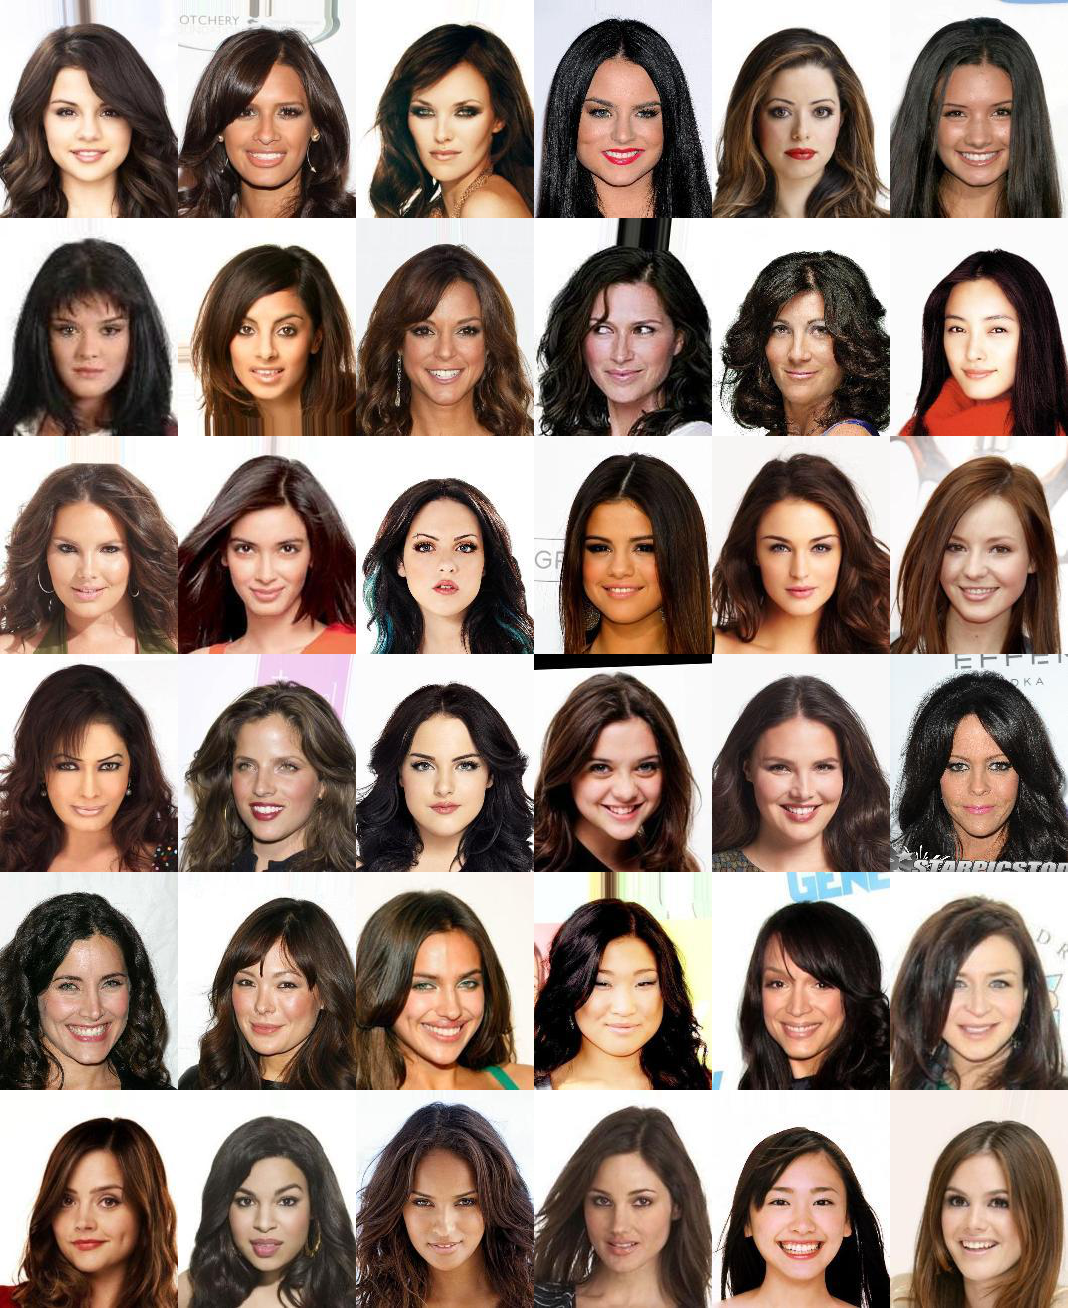

In [9]:
top_grid = grid(top_images, 6, 6)

top_grid.save(root/"results/Experiment5/top36_female_autoencoder.pdf")
display(top_grid)

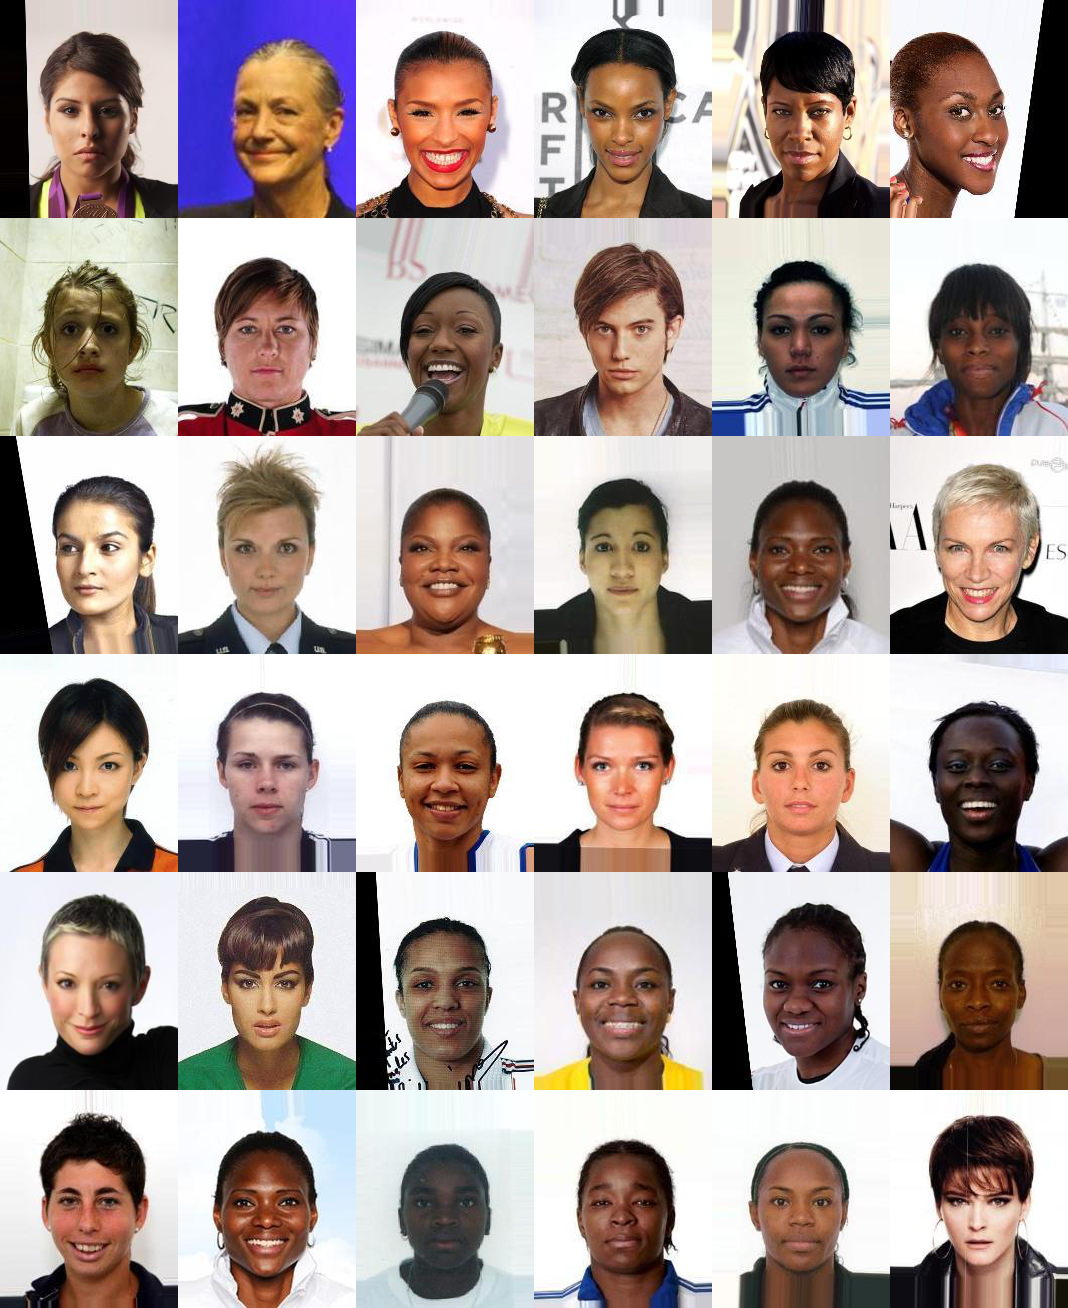

In [10]:
bottom_grid = grid(bottom_images, 6, 6)

bottom_grid.save(root/"results/Experiment5/bottom36_female_autoencoder.pdf")
display(bottom_grid)

In [11]:
attributes = list(set(female.columns)-{"image_id", "Male", "autoencoder_Kantorovich_potential"})
stats = list()
p_val= list()

for attr in attributes:
    
    col1 = female[female[attr] == 1].autoencoder_Kantorovich_potential
    col2 = female[female[attr] == -1].autoencoder_Kantorovich_potential
        
    test = ks_2samp(col1, col2)

    stats.append(test.statistic)
    p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes, "statistic" : stats, "pvalue" : p_val})
table.set_index("attribute", inplace=True)

ValueError: Data passed to ks_2samp must not be empty

In [14]:
print(table.to_latex())

NameError: name 'table' is not defined

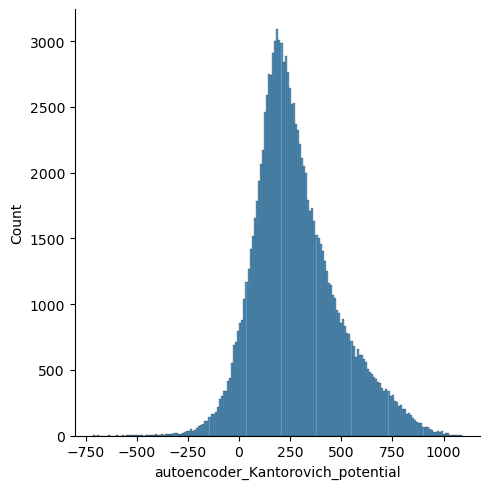

In [12]:
potentials = female["autoencoder_Kantorovich_potential"]

sns.displot(potentials)
plt.show()

In [13]:
quantiles_top = np.percentile(potentials, np.arange(10,100,10)+2)
quantiles_bottom = np.percentile(potentials, np.arange(10,100,10)-2)

In [14]:
quantiles_top

array([ 67.57762695, 128.69912354, 172.30424316, 211.57421875,
       254.42787109, 304.05533203, 367.30262695, 454.15128174,
       601.37789551])

In [15]:
quantiles_bottom

array([ 31.72708496, 107.55726074, 155.56754883, 195.59354492,
       236.51924805, 283.07277344, 339.64709961, 415.12238281,
       531.05891602])

In [16]:
def open_array(path):
    tensor = torch.load(path)
    
    return tensor.detach().numpy()

data = np.concatenate([open_array(celeba_folder/"resnet18"/"{}.pt".format(file[:-4])) for file in female.image_id])

In [17]:
scaler = MinMaxScaler()

In [18]:
data = scaler.fit_transform(data)

In [19]:
import kmapper as km

In [116]:
from src.mapper import Mapper

In [137]:
projected_data = np.array(female.autoencoder_Kantorovich_potential)

In [138]:
mapper = Mapper(data, projected_data)

In [139]:
mapper.fit()

In [140]:
g = mapper.graph

In [143]:
for i in mapper.df[mapper.df.notna().sum(axis = 1) > 1].index:
    for j, k in itertools.combinations(mapper.df.columns[np.array(mapper.df.loc[i].notna())], 2):
        g.add_edge((j, int(mapper.df.loc[i,j])), (j, int(mapper.df.loc[i,k])))

In [144]:
mapper.graph.edges()

EdgeView([(('9', 0), ('9', 0)), (('9', 0), ('9', 1)), (('9', 1), ('9', 1)), (('0', 1), ('0', 1)), (('0', 1), ('0', 0)), (('0', 0), ('0', 0))])

In [131]:
print(list(np.array(mapper.df[["8","9"]])))

[array([nan,  1.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  1.]), array([nan,  0.]), array([nan,  0.]), array([nan,  0.]), array([nan,  1.]), array([nan,  0.]), array([nan,  1.]), array([nan,

In [100]:
import itertools

In [47]:
mapper.df

(0,0)  (0,1)  (1,0)  (1,1)  (2,0)  (2,1)  (3,0)  (3,1)  (4,0)  (4,1)  \
0         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
118160    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
118161    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
118162    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
118163    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
118164    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        (5,0)  (5,1)  (6,0)  (6,1)  (7,0)  (7,1)  (8,0)  (8,1)  (9,0)  
0         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...       ...    ...    ...    ...    ...    ...    ...    ...    ...  
118160    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
118161    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
118162    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
118163    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
118164    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[118165 rows x 19 columns]

In [ ]:
mapper = km.KeplerMapper(verbose=1)

In [27]:
projected_data = projected_data.reshape(-1,1)

In [22]:
cover = km.Cover(n_cubes=10, perc_overlap=0.1)

In [32]:
graph = mapper.map(projected_data, data, cover=cover, clusterer=sklearn.cluster.OPTICS())

Mapping on data shaped (118165, 512) using lens shaped (118165, 1)

Creating 10 hypercubes.


KeyboardInterrupt: 

In [ ]:
cover.fit_transform(data)

In [31]:
graph 

{'nodes': defaultdict(list, {}),
 'links': defaultdict(list, {}),
 'simplices': [],
 'meta_data': {'projection': 'custom',
  'n_cubes': 10,
  'perc_overlap': 0.5,
  'clusterer': 'DBSCAN()',
  'scaler': 'None'},
 'meta_nodes': defaultdict(list, {})}

In [43]:
html = mapper.visualize(graph, path_html="../results/Experiment5/celeba_keplermapper_output.html",
                 title="")

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title> | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weight: 700;\n  te

In [20]:
for file in female.image_id:
    print(celeba_folder/"resnet18"/file)
    break

../data/celeba/resnet18/005886.jpg
